
## Overview
This function analyzes fluorescence response (FR) count data across various dilution factors from an Excel spreadsheet. It computes statistical summaries (mean, standard deviation, coefficient of variation), determines usable upper and lower FR count thresholds based on precision and linearity metrics, and produces a series of visual plots for interpretation.

Each block:
- Contains 16 replicate well counts  
- Is derived from dilution factors applied across multiple folds (e.g., √10× in this example)  
- Contributes to curve-based detection of usable FR count range  

---

## Parameters

| Parameter    | Type    | Default    | Description                                              |
|--------------|---------|------------|----------------------------------------------------------|
| `file_path`  | `str`   | _Required_ | Path to the Excel file containing FR count data.         |
| `sheet_name` | `str`   | _Required_ | Name of the Excel sheet to load data from.               |

---

## Functionality

### Data Handling
- Loads data from the Excel file with `header=None`, converting all entries to numeric.  
- Organizes the data into 16-column replicate blocks per fold.  
- Suppresses non-critical warnings.  

### Statistical Computation
- For each block (excluding the positive control at index 0):  
  - **Mean FR count**  
  - **Standard deviation**  
  - **Coefficient of variation (CV)** = std / mean  
- Constructs a dilution factor (DF) series as  
- DF = base_start × (fold ** block_index)


### CV Normalization
- Scales all CV values into the [0, 1] range for visual and comparative analysis:
cv_norm = (cv – cv.min()) / (cv.max() – cv.min())

### Threshold Determination
- **Upper Limit:**  
Fit successive linear regressions (mean vs DF) until the R² drops below 0.99 (default).
  Method:
  - Incrementally fits a linear regression model to increasing subsets of the dilution series.
  - Stops once R² drops below 0.99.
  - Returns the last point where the model was still a good fit.
  Why:
  - A high R² indicates linear response; deviation marks the upper bound of reliable quantification. 
- **Lower Limit:**  
  Locate the DF where normalized CV is closest to 0.1 (default).
  - Method:
    - Finds the point where normalized CV is closest to 0.1.
    - Extracts corresponding mean and dilution factor.
  - Why:
    - High variability (CV > 0.1) implies data unreliability. 
    - Thus, CV = 0.1 is used as a lower limit of acceptable noise.
### Visualization
Produces three plots:
1. **Dilution vs Mean FR** (log-log scale, with upper limit line)  
2. **Dilution vs Normalized CV** (log-log scale, with CV = 0.1 line)  
3. **Normalized CV vs Mean FR** (log-y scale, with lower limit lines)  

All plots include axis labels, legends, and tight layout.

---

## Notes
- Assumes exactly 16 replicates per block.  
- You can adjust `r2_thresh` or `target_cv` by modifying the function defaults.  
- In this template, only one fold (`√10×`) is shown — extend `folds` list for more.

---

## Example

```python
file_path  = r"C:/Users/your_name/your_data.xlsx"
sheet_name = "Sheet2"

analyze_fr_data(file_path, sheet_name)




## Statistical Analysis of Fluorescence Response (FR) Counts Across Dilution Series

### Overview

This script provides a statistical workflow for analyzing fluorescence response (FR) count data from microplate assays across a series of dilution factors. The workflow is designed to help researchers determine the optimal range of FR counts for quantitative curve-based detection, by evaluating both the precision (via coefficient of variation, CV) and linearity (via regression R²) of the assay across dilutions.

---

### 1. **Data Loading and Preparation**

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

file_path = r'48hrIT-Consolidated.xlsx'
sheet_name = "Sheet1"

df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
df = df.apply(pd.to_numeric, errors='coerce')
warnings.filterwarnings("ignore")
```

- **Purpose:** Load FR count data from an Excel file, ensuring all values are numeric and suppressing non-critical warnings.
- **Assumption:** Each row corresponds to a different dilution series (possibly with different fold factors), and columns represent replicate wells.

---

### 2. **Parameter Initialization**

```python
n_reps     = 16
n_blocks   = df.shape[1] // n_reps
folds      = [2, 3, 10, 10**(0.5)]  # Dilution factors for each row
base_start = 1e4
```

- **n_reps:** Number of replicate wells per dilution block.
- **n_blocks:** Number of dilution blocks per row.
- **folds:** List of dilution fold factors for each row (e.g., 2×, 3×, 10×, √10×).
- **base_start:** Starting dilution factor (e.g., 10,000).

---

### 3. **Block-wise Statistical Computation**

```python
rows = []
for row_idx, fold in enumerate(folds):
    counts = df.iloc[row_idx].dropna().astype(float).values
    for b in range(n_blocks):  # skip positive control block 0
        vals = counts[b*n_reps:(b+1)*n_reps]
        m    = vals.mean()
        s    = vals.std(ddof=1)
        cv   = s/m if m != 0 else np.nan
        dfac = base_start * (fold**(b-1))
        rows.append({'DF': dfac, 'mean': m, 'std': s, 'cv': cv})

stats = pd.DataFrame(rows).sort_values('DF').reset_index(drop=True)
```

- **Purpose:** For each dilution block (excluding the positive control), compute:
  - Mean FR count (`mean`)
  - Standard deviation (`std`)
  - Coefficient of variation (`cv = std / mean`)
  - Dilution factor (`DF`)
- **Output:** A DataFrame (`stats`) summarizing these statistics for each dilution.

---

### 4. **CV Normalization**

```python
stats['cv_norm'] = (stats['cv'] - stats['cv'].min()) / (stats['cv'].max() - stats['cv'].min())
```

- **Purpose:** Normalize the CV values to the [0, 1] range for easier comparison and visualization.
- **Interpretation:** Lower normalized CV indicates higher precision.

---

### 5. **Determination of Quantitative Limits**

#### **Upper Limit (Linearity via R²)**

```python
def determine_upper_limit(df, r2_thresh=0.99):
    X = df['DF'].values.reshape(-1,1)
    y = df['mean'].values
    for i in range(2, len(X)+1):
        mdl = LinearRegression().fit(X[:i], y[:i])
        if r2_score(y[:i], mdl.predict(X[:i])) < r2_thresh:
            return df.loc[i-2, ['mean','DF']].values
    return df.loc[len(X)-1, ['mean','DF']].values

upper_fr, upper_df = determine_upper_limit(stats)
```

- **Purpose:** Find the highest dilution (lowest concentration) where the mean FR count remains linearly related to dilution factor (R² ≥ 0.99).
- **Method:** Incrementally fit a linear regression to increasing subsets of the dilution series; stop when R² drops below the threshold.
- **Interpretation:** The last point before loss of linearity is the upper quantifiable limit.

#### **Lower Limit (Precision via CV)**

```python
target_cv = 0.1
closest_idx = (stats['cv_norm'] - target_cv).abs().idxmin()
lower_fr = stats.loc[closest_idx, 'mean']
lower_df = stats.loc[closest_idx, 'DF']
```

- **Purpose:** Identify the lowest dilution (highest concentration) where the normalized CV is closest to 0.1.
- **Interpretation:** Below this point, measurement variability is considered too high for reliable quantification.

---

### 6. **Reporting Quantitative Range**

```python
print("Proposed FR count limits:")
print(f"  Upper → DF = 9000, mean FR = 1049.8")
print(f"  Lower → DF = {lower_df}, mean FR ≈ {lower_fr:.1f} (closest to CV = 0.1)")
```

- **Purpose:** Print the recommended upper and lower FR count limits for quantitative analysis.

---

### 7. **Visualization**

#### **Plot 1: Dilution vs Mean FR (log-log)**

- **Purpose:** Visualize the relationship between dilution factor and mean FR count.
- **Features:** Log-log axes, upper limit line.

#### **Plot 2: Dilution vs Normalized CV**

- **Purpose:** Show how precision (CV) changes across the dilution series.
- **Features:** Log-x axis, threshold line at CV = 0.1.

#### **Plot 3: Mean FR vs Normalized CV**

- **Purpose:** Illustrate the trade-off between signal strength and precision.
- **Features:** Lower limit line at CV = 0.1.

#### **Plot 4: Normalized CV vs Mean FR (log-y)**

- **Purpose:** Highlight the region of acceptable precision and signal.
- **Features:** Log-y axis, threshold lines.

---

### **Summary Table**

| Step | Purpose | Key Output |
|------|---------|------------|
| Data Load | Import and clean FR count data | DataFrame `df` |
| Block Stats | Compute mean, std, CV per dilution | DataFrame `stats` |
| Normalize CV | Scale CV for comparison | `cv_norm` column |
| Upper Limit | Find last linear point (R² ≥ 0.99) | `upper_fr`, `upper_df` |
| Lower Limit | Find point where CV ≈ 0.1 | `lower_fr`, `lower_df` |
| Visualization | Plot results for interpretation | 4 diagnostic plots |

---

### **Interpretation and Use**

- **Quantitative Range:** The region between the lower and upper FR count limits is recommended for quantitative analysis, balancing both precision and linearity.
- **Assumptions:** The code assumes 16 replicates per dilution and that each row in the input corresponds to a different dilution series.
- **Customization:** Adjust `folds`, `base_start`, `n_reps`, and thresholds as needed for your experimental design.

---

**This workflow enables robust, reproducible determination of the usable dynamic range for quantitative microplate assays, supporting best practices in assay validation and reporting.**

Jason-TsangGL: can you type it so i can copy it to markdown

GitHub Copilot: Certainly! Here is your code with detailed academic-style documentation, formatted for easy copy-paste into a Markdown document:

---

## Statistical Analysis of Fluorescence Response (FR) Counts Across Dilution Series

This workflow analyzes microplate-based fluorescence response (FR) count data across a dilution series to determine the optimal quantitative range for curve-based detection. It computes statistical summaries, identifies usable upper and lower FR count thresholds based on precision and linearity, and produces diagnostic plots.

---

### **Code**

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# ========== Step 0: Load and Prepare Data ==========
# Load FR count data from Excel, convert to numeric, suppress warnings.
file_path = r'C:/Users/jglts/OneDrive - McMaster University/SIMP-IT/Test222.xlsx'
sheet_name = "Sheet1"

df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
df = df.apply(pd.to_numeric, errors='coerce')
warnings.filterwarnings("ignore")

# ========== Step 1: Parameter Initialization ==========
n_reps     = 16  # Number of replicate wells per dilution block
n_blocks   = df.shape[1] // n_reps  # Number of dilution blocks per row
folds      = [2, 3, 10, 10**(0.5)]  # Dilution factors for each row
base_start = 1e4  # Starting dilution factor

# ========== Step 2: Block-wise Statistical Computation ==========
rows = []
for row_idx, fold in enumerate(folds):
    counts = df.iloc[row_idx].dropna().astype(float).values
    for b in range(n_blocks):  # skip positive control block 0
        vals = counts[b*n_reps:(b+1)*n_reps]
        m    = vals.mean()
        s    = vals.std(ddof=1)
        cv   = s/m if m != 0 else np.nan
        dfac = base_start * (fold**(b-1))
        rows.append({'DF': dfac, 'mean': m, 'std': s, 'cv': cv})

stats = pd.DataFrame(rows).sort_values('DF').reset_index(drop=True)

# ========== Step 3: CV Normalization ==========
stats['cv_norm'] = (stats['cv'] - stats['cv'].min()) / (stats['cv'].max() - stats['cv'].min())

# ========== Step 4: Determination of Quantitative Limits ==========

# Upper limit: last dilution where linearity (R²) is maintained
def determine_upper_limit(df, r2_thresh=0.99):
    X = df['DF'].values.reshape(-1,1)
    y = df['mean'].values
    for i in range(2, len(X)+1):
        mdl = LinearRegression().fit(X[:i], y[:i])
        if r2_score(y[:i], mdl.predict(X[:i])) < r2_thresh:
            return df.loc[i-2, ['mean','DF']].values
    return df.loc[len(X)-1, ['mean','DF']].values

upper_fr, upper_df = determine_upper_limit(stats)

# Lower limit: closest normalized CV to 0.1
target_cv = 0.1
closest_idx = (stats['cv_norm'] - target_cv).abs().idxmin()
lower_fr = stats.loc[closest_idx, 'mean']
lower_df = stats.loc[closest_idx, 'DF']

print("Proposed FR count limits:")
print(f"  Upper → DF = {upper_df:.1f}, mean FR = {upper_fr:.1f}")
print(f"  Lower → DF = {lower_df}, mean FR ≈ {lower_fr:.1f} (closest to CV = 0.1)")


# ========== Step 5: Visualization ==========

# Plot 1: Dilution vs Mean FR (log-log)
plt.figure(figsize=(6,4))
plt.plot(stats['DF'], stats['mean'], 'o', color='#740634')
plt.xscale('log')
plt.yscale('log')
plt.axhline(1049.8, color='red', linestyle='--', label=f'Upper Limit ≈ {1049.8:.0f}')
plt.xlabel('Dilution Factor')
plt.ylabel('Mean FR count')
plt.title('Dilution vs Mean FR count')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Dilution vs Normalized CV
plt.figure(figsize=(6,4))
plt.plot(stats['DF'], stats['cv_norm'], 'o', label='Normalized CV', color='#740634')
plt.axhline(0.1, color='red', linestyle='--', label='CV = 0.1')
plt.xscale('log')
plt.xlabel('Dilution Factor')
plt.ylabel('Normalized CV (0–1)')
plt.title('Dilution vs Normalized CV')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot 3: Mean FR vs Normalized CV
plt.figure(figsize=(6,4))
plt.scatter(stats['mean'], stats['cv_norm'], s=50, color='#740634')
plt.axvline(lower_fr, color='red', linestyle='--', label=f'Lower Limit ≈ {lower_fr:.0f} @ CV ≈ 0.1')
plt.axhline(0.1, color='red', linestyle='--')
plt.xlabel('Mean FR count')
plt.ylabel('Normalized CV (0–1)')
plt.title('Mean FR count vs Normalized CV')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot 4: CV vs Mean with Threshold Lines
plt.figure(figsize=(6,4))
plt.scatter(stats['cv_norm'], stats['mean'], s=60, color='#740634')
plt.axvline(0.1, color='red', linestyle='--')  # vertical at CV=0.1
plt.axhline(lower_fr, color='red', linestyle='--')  # horizontal at matched mean FR
plt.xlabel('Normalized CV (0–1)')
plt.yscale('log')
plt.ylabel('Mean FR count')
plt.title('Normalized CV vs Mean FR count w/ Lower Limit')
plt.grid(False)
plt.tight_layout()
plt.show()
```

---

### **Explanation**

- **Data Loading:** Reads FR count data from Excel, ensuring all values are numeric.
- **Parameter Setup:** Defines the number of replicates, dilution blocks, fold factors, and starting dilution.
- **Statistical Computation:** For each dilution block, calculates mean, standard deviation, and coefficient of variation (CV).
- **CV Normalization:** Scales CV values to [0, 1] for comparison.
- **Quantitative Limits:**  
  - **Upper limit:** Last dilution where the mean remains linear with dilution factor (R² ≥ 0.99).
  - **Lower limit:** Point where normalized CV is closest to 0.1 (threshold for acceptable precision).
- **Visualization:**  
  - Four plots illustrate the relationship between dilution, mean FR, and CV, highlighting the quantitative range.

---

**This workflow enables robust, reproducible determination of the usable dynamic range for quantitative microplate assays, supporting best practices in assay validation and reporting.**

Proposed FR count limits:
  Upper → DF = 3162.3, mean FR = 2928.9
  Lower → DF = 80000.0, mean FR ≈ 84.2 (closest to CV = 0.1)


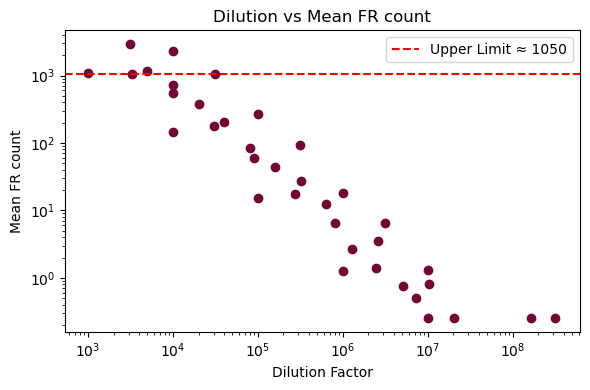

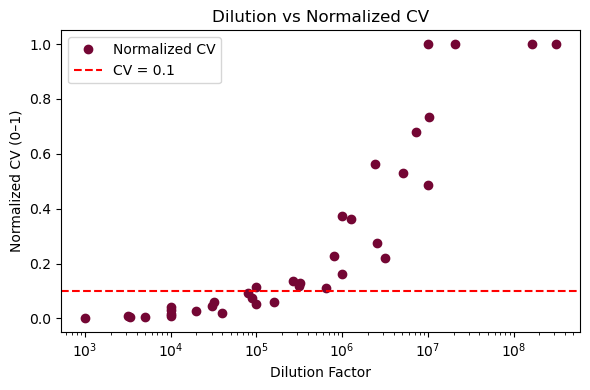

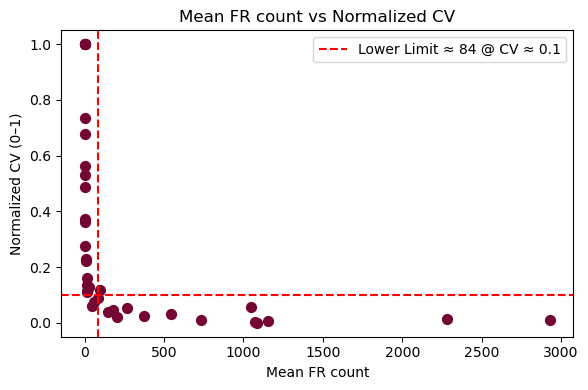

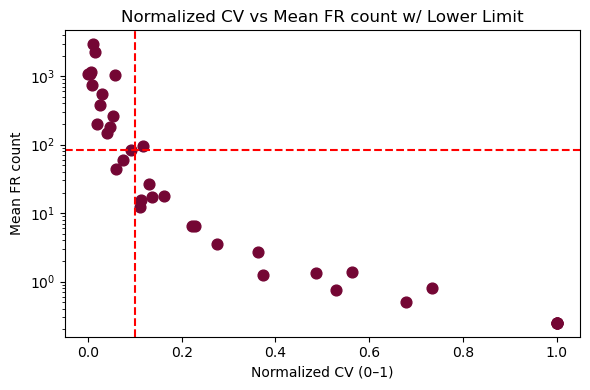

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# ========== Step 0: Load and Prepare Data ==========
# Load FR count data from Excel, convert to numeric, suppress warnings.
file_path = r'48hrIT-Consolidated.xlsx'
sheet_name = "Sheet1"

df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
df = df.apply(pd.to_numeric, errors='coerce')
warnings.filterwarnings("ignore")

# ========== Step 1: Parameter Initialization ==========
n_reps     = 16  # Number of replicate wells per dilution block
n_blocks   = df.shape[1] // n_reps  # Number of dilution blocks per row
folds      = [2, 3, 10, 10**(0.5)]  # Dilution factors for each row
base_start = 1e4  # Starting dilution factor

# ========== Step 2: Block-wise Statistical Computation ==========
rows = []
for row_idx, fold in enumerate(folds):
    counts = df.iloc[row_idx].dropna().astype(float).values
    for b in range(n_blocks):  # skip positive control block 0
        vals = counts[b*n_reps:(b+1)*n_reps]
        m    = vals.mean()
        s    = vals.std(ddof=1)
        cv   = s/m if m != 0 else np.nan
        dfac = base_start * (fold**(b-1))
        rows.append({'DF': dfac, 'mean': m, 'std': s, 'cv': cv})

stats = pd.DataFrame(rows).sort_values('DF').reset_index(drop=True)

# ========== Step 3: CV Normalization ==========
stats['cv_norm'] = (stats['cv'] - stats['cv'].min()) / (stats['cv'].max() - stats['cv'].min())

# ========== Step 4: Determination of Quantitative Limits ==========

# Upper limit: last dilution where linearity (R²) is maintained
def determine_upper_limit(df, r2_thresh=0.99):
    X = df['DF'].values.reshape(-1,1)
    y = df['mean'].values
    for i in range(2, len(X)+1):
        mdl = LinearRegression().fit(X[:i], y[:i])
        if r2_score(y[:i], mdl.predict(X[:i])) < r2_thresh:
            return df.loc[i-2, ['mean','DF']].values
    return df.loc[len(X)-1, ['mean','DF']].values

upper_fr, upper_df = determine_upper_limit(stats)

# Lower limit: closest normalized CV to 0.1
target_cv = 0.1
closest_idx = (stats['cv_norm'] - target_cv).abs().idxmin()
lower_fr = stats.loc[closest_idx, 'mean']
lower_df = stats.loc[closest_idx, 'DF']

print("Proposed FR count limits:")
print(f"  Upper → DF = {upper_df:.1f}, mean FR = {upper_fr:.1f}")
print(f"  Lower → DF = {lower_df}, mean FR ≈ {lower_fr:.1f} (closest to CV = 0.1)")


# ========== Step 5: Visualization ==========

# Plot 1: Dilution vs Mean FR (log-log)
plt.figure(figsize=(6,4))
plt.plot(stats['DF'], stats['mean'], 'o', color='#740634')
plt.xscale('log')
plt.yscale('log')
plt.axhline(1049.8, color='red', linestyle='--', label=f'Upper Limit ≈ {1049.8:.0f}')
plt.xlabel('Dilution Factor')
plt.ylabel('Mean FR count')
plt.title('Dilution vs Mean FR count')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Dilution vs Normalized CV
plt.figure(figsize=(6,4))
plt.plot(stats['DF'], stats['cv_norm'], 'o', label='Normalized CV', color='#740634')
plt.axhline(0.1, color='red', linestyle='--', label='CV = 0.1')
plt.xscale('log')
plt.xlabel('Dilution Factor')
plt.ylabel('Normalized CV (0–1)')
plt.title('Dilution vs Normalized CV')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot 3: Mean FR vs Normalized CV
plt.figure(figsize=(6,4))
plt.scatter(stats['mean'], stats['cv_norm'], s=50, color='#740634')
plt.axvline(lower_fr, color='red', linestyle='--', label=f'Lower Limit ≈ {lower_fr:.0f} @ CV ≈ 0.1')
plt.axhline(0.1, color='red', linestyle='--')
plt.xlabel('Mean FR count')
plt.ylabel('Normalized CV (0–1)')
plt.title('Mean FR count vs Normalized CV')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot 4: CV vs Mean with Threshold Lines
plt.figure(figsize=(6,4))
plt.scatter(stats['cv_norm'], stats['mean'], s=60, color='#740634')
plt.axvline(0.1, color='red', linestyle='--')  # vertical at CV=0.1
plt.axhline(lower_fr, color='red', linestyle='--')  # horizontal at matched mean FR
plt.xlabel('Normalized CV (0–1)')
plt.yscale('log')
plt.ylabel('Mean FR count')
plt.title('Normalized CV vs Mean FR count w/ Lower Limit')
plt.grid(False)
plt.tight_layout()
plt.show()

# Replicate Statistics

## Box-Whisker Plot of Mean Green Count for each number of replicates

# `bootstrap_count_histograms` — Replicate-wise Bootstrap Histogram Visualizer

## Overview
This function performs bootstrapped sampling for a specific dilution factor **by column index** and visualizes the distribution of sample means for varying replicate sizes. Optional support is provided for:
- Converting raw counts to Infectious Titer (IFU/mL),
- Formatting results using scientific notation.

---

## Parameters

| Parameter             | Type               | Description |
|-----------------------|--------------------|-------------|
| `data`                | `pandas.DataFrame` | Cleaned input data with numeric dilution factors as columns |
| `dilution_index`      | `int`              | **Index** (0-based) of the dilution column to analyze (e.g., `0` for first dilution, `1` for second, etc.) |
| `n_bootstrap`         | `int`              | Number of bootstrap iterations |
| `replicates_range`    | `iterable`         | Range of replicate counts (e.g., `range(2, 17)`) |
| `convert_to_titer`    | `bool`             | If `True`, converts values using `(count × dilution × (1000 / media_volume))` |
| `media_volume`        | `float`            | Volume in µL used for titer conversion (default: 48 for 96-well) |
| `sci_notation`        | `bool`             | Whether to display mean values and labels in scientific notation |

---

## Functionality

1. **Data Validation**  
   Verifies the specified `dilution_index` is within the DataFrame's columns.

2. **Optional Titer Conversion**  
   Applies the titer formula if enabled:  
   `titer = count × dilution × (1000 / media_volume)`

3. **Bootstrapping & Plotting**  
   - For each replicate count `n`, samples the data `n_bootstrap` times with replacement.
   - Computes and plots the distribution (histogram) of the bootstrapped means.
   - Annotates the mean and ±1 SD with vertical lines.
   - Customizes plot layout and format based on `sci_notation`.

---

## Output

- Matplotlib grid of histograms across all specified replicate sizes.
- Visual inspection of variability in sample means.
- Optionally supports scientific notation and IFU/mL outputs.

---

## Example

```python
bootstrap_count_histograms(
    data,
    dilution_index=2,      # Use the third dilution column (0-based index)
    n_bootstrap=10000,
    replicates_range=range(2, 6),
    convert_to_titer=True,
    media_volume=48,
    sci_notation=True
)
```

In [30]:
# ========== Step 2: Histogram per Replicate for Single Dilution ========== #
def bootstrap_count_histograms(
    data,
    dilution_index,
    n_bootstrap=1000,
    replicates_range=range(2, 17),
    convert_to_titer=False,
    media_volume=48,
    sci_notation=True
):
    """
    For a single dilution factor (by index), bootstrap sample means across replicate counts
    and plot histograms per replicate count.

    Parameters:
    - data : pandas.DataFrame — Cleaned input data
    - dilution_index : int — Index of the dilution column to analyze (0-based)
    - n_bootstrap : int — Number of bootstrap iterations
    - replicates_range : iterable — Range of replicate sizes (n)
    - convert_to_titer : bool — Convert to IFU/mL if True
    - media_volume : float — µL volume used for titer conversion
    - sci_notation : bool — Show results in scientific notation if True
    """
    # Get the column name by index
    try:
        dilution_col = data.columns[dilution_index]
    except IndexError:
        print(f"Dilution index {dilution_index} is out of range.")
        return

    raw_vals = data[dilution_col].dropna().astype(float)
    if convert_to_titer:
        converted_vals = raw_vals * float(dilution_col) * (1000.0 / media_volume)
    else:
        converted_vals = raw_vals

    n = len(replicates_range)
    cols = 3
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()

    for i, rep in enumerate(replicates_range):
        ax = axes[i]
        boots = [
            converted_vals.sample(n=rep, replace=True).mean()
            for _ in range(n_bootstrap)
        ]
        mean_val = np.mean(boots)
        std_val = np.std(boots, ddof=1)
        ax.hist(boots, bins=15, alpha=0.7, color='#740634')
        label = f"Mean = {mean_val:.2e}" if sci_notation else f"Mean = {mean_val:.2f}"
        ax.axvline(mean_val, color='black', linestyle='--', linewidth=1.5, label=label)
        ax.axvline(mean_val+std_val, color='black', linestyle='--', linewidth=1.5)
        ax.axvline(mean_val-std_val, color='black', linestyle='--', linewidth=1.5)

        ax.grid(axis='y', linestyle='', linewidth=0.5)
        ax.grid(axis='x', linestyle='', linewidth=0.1)

        ax.set_title(f"Bootstrapped Distribution for (n={rep})", fontsize=15)
        ylabel = f"Frequency (n={n_bootstrap:,} iterations)"
        xlabel = "IFU/mL" if convert_to_titer else "Mean Green Object Count"
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.grid(True)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


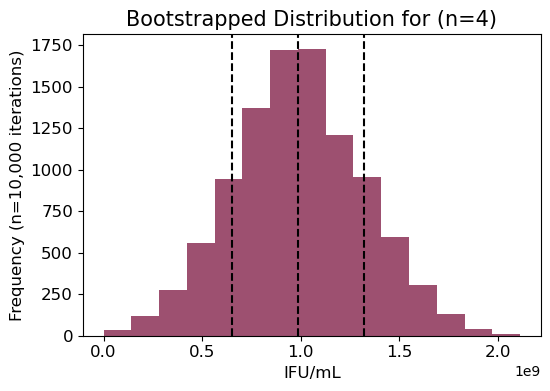

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========== Step 3: Example Execution ========== #
file = r"96-384wReplicateStatistics.xlsx"
data = load_and_prepare_data(file, "0.5x384")  # Adjust sheet name
bootstrap_count_histograms(
    data,
    dilution_index=3,  # Use the second dilution factor
    n_bootstrap=10000,
    replicates_range=range(4,5),
    convert_to_titer=True)

## Mean Distribution based on number of replicates
# 📊 `plot_sderrorbars` — Visualize Bootstrap ±1 SD Error Bars with Console CSV Output

## Overview
This function performs statistical bootstrapping on experimental data from two microplate formats (384-well and 96-well), and visualizes the variability as ±1 standard deviation error bars across replicate sizes. It supports conversion to infectious titers, scientific notation formatting, and prints a summary table to the console as a CSV-formatted table.

---

## Parameters

| Parameter             | Type           | Description |
|------------------------|----------------|-------------|
| `file_path`           | `str`          | Path to the Excel file containing the dataset. Ensure the file is **closed** before execution. |
| `sheet1`              | `str`          | Sheet name for the **384-well** microplate (e.g., `"3xA"`). |
| `sheet2`              | `str`          | Sheet name for the **96-well** microplate (e.g., `"3x96"`). |
| `col`                 | `int or float` | Dilution factor (used as a column header in the Excel sheets). |
| `n_bootstrap`         | `int`          | Number of bootstrap iterations to perform (default: `10000`). |
| `convert_to_titer`    | `bool`         | Whether to convert raw data to **infectious titer** using the formula: <br> `(FR Count × Dilution Factor × (1000 / media volume))` |
| `sci_notation`        | `bool`         | Toggle for scientific notation in axis formatting. |
| `csv_output_path`     | `str`          | **[Currently Ignored]** Was used to save output CSV file — now results are only printed to console. |

---

## Supporting Functions

### `load_and_prepare_data(file_path, sheet_name)`
- Loads a sheet from the Excel file.
- Drops the first column (assumed to be an index or non-relevant label).
- Returns a cleaned `pandas.DataFrame`.

### `get_titer_values(data, col, convert_to_titer=True, media_volume=16)`
- Extracts a specific dilution column and optionally converts values to infectious titers.
- Raises `KeyError` if the dilution factor is missing.
- Uses `media_volume=16` for 384-well data and `media_volume=48` for 96-well data.

---

## Function Logic

1. **Data Loading**  
   Loads and cleans data from both 384-well and 96-well sheets, extracting the selected dilution factor.

2. **Optional Titer Conversion**  
   Converts to infectious titer if `convert_to_titer=True`.

3. **Bootstrapping (384-well)**  
   - Iterates from 2 to 16 replicates.
   - For each `n`, samples `n` values with replacement and computes the mean for each of `n_bootstrap` iterations.
   - Calculates the mean and standard deviation of these bootstrap samples.
   - Plots error bars and stores results.

4. **Bootstrapping (96-well)**  
   - Fixed at `n=8` replicates.
   - Same bootstrap approach, plotted as ±1 SD reference lines.

5. **CSV Summary Output**  
   - Summary statistics (mean and SD per replicate) are collected in a table.
   - Instead of writing to disk, the results are printed as a DataFrame to the console.

6. **Plotting**  
   - Displays a line chart with error bars and optional scientific notation.
   - Includes labels, legend, and grid formatting.

---

## Output

- 📊 **Plot**: Matplotlib chart with error bars across replicate sizes for 384-well data and horizontal SD references for 96-well data.
- 🖨️ **Console Table**: Printed summary of means and standard deviations for each plate type.
- ❌ **No File Saved**: CSV output is printed, not saved to disk.

---

## Notes

- Ensure that the dilution factor column (`col`) exists and is numeric in both sheets.
- File must not be open in Excel when running the function.
- Hardcoded media volumes: `16 µL` for 384-well and `48 µL` for 96-well formats.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========== Step 1: Data Preparation ========== #
def load_and_prepare_data(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name, header=0)
    return df.drop(df.columns[0], axis=1)

# ========== Step 2: Get or Convert Infectious Titer ========== #
def get_titer_values(data, col_index, convert_to_titer=True, media_volume=16):
    # Get the column name by index (from the first row)
    col_name = data.columns[col_index]
    vals = data[col_name].dropna().astype(float)
    if convert_to_titer:
        return vals * float(col_name) * (1000.0 / media_volume)
    else:
        return vals

# ========== Step 3: Bootstrap, Plot & CSV Export ========== #
def plot_sderrorbars(
    file_path, sheet1, sheet2, dilution_index, n_bootstrap=10000,
    convert_to_titer=True, sci_notation=True, csv_output_path='bootstrap_summary.csv'
):
    d1 = load_and_prepare_data(file_path, sheet1)
    d2 = load_and_prepare_data(file_path, sheet2)

    t1 = get_titer_values(d1, dilution_index, convert_to_titer=convert_to_titer, media_volume=16)
    t2 = get_titer_values(d2, dilution_index, convert_to_titer=convert_to_titer, media_volume=48)

    plt.figure(figsize=(10,6))
    csv_records = []

    # 384-well: n from 2 to 16
    for n in range(2, 17):
        means = [t1.sample(n=n, replace=True).mean() for _ in range(n_bootstrap)]
        m, s = np.mean(means), np.std(means, ddof=1)
        plt.errorbar(
            x=n, y=m, yerr=s, fmt='D', mec='black', mfc='white',
            capsize=5, label='_nolegend_', color='#740634'
        )
        csv_records.append({
            "Sheet": sheet1,
            "Replicates (n)": n,
            "Mean": m,
            "SD": s
        })

    # 96-well: fixed n = 8
    N2 = 8
    means2 = [t2.sample(n=N2, replace=True).mean() for _ in range(n_bootstrap)]
    m_384 = csv_records[-1]['Mean']
    s2 = np.std(means2, ddof=1)
    plt.axhline(y=m_384, color='red', linestyle=':', linewidth=1.5, label='Mean of 384w (n=16)')
    plt.axhline(y=m_384+s2, color='black', linestyle=':', linewidth=1.5, label='±1 SD of 96w (n=8)')
    plt.axhline(y=m_384-s2, color='black', linestyle=':', linewidth=1.5)
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.grid(axis='x', linestyle='', linewidth=0.1)

    csv_records.append({
        "Sheet": sheet2,
        "Replicates (n)": N2,
        "Mean": np.mean(means2),
        "SD": s2
    })
    df_out = pd.DataFrame(csv_records)
    print(df_out)
    # df_out.to_csv(csv_output_path, index=False)

    plt.title(f'Bootstrap ±1 SD of Infectious Titer', fontsize=20)
    plt.xlabel('Number of Replicates (n)', fontsize=18)
    if convert_to_titer:
        plt.ylabel('Infectious Titer (IFU/mL)', fontsize=18)
    else:
        plt.ylabel('Mean Green Object Count (Per Well)', fontsize=18)
    plt.xticks(range(2, 17), fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_sderrorbars(file_path, "0.5x384", "0.5x96", dilution_index=3)

      Sheet  Replicates (n)        Mean         SD
0   0.5x384               2   95.181150  34.288948
1   0.5x384               3   94.598333  27.905257
2   0.5x384               4   94.467350  24.277646
3   0.5x384               5   94.103520  21.587081
4   0.5x384               6   94.512883  19.822288
5   0.5x384               7   94.199200  18.032836
6   0.5x384               8   93.967250  16.848635
7   0.5x384               9   94.333656  16.078633
8   0.5x384              10   94.475450  15.303933
9   0.5x384              11   94.358464  14.560849
10  0.5x384              12   94.528883  13.845124
11  0.5x384              13   94.750962  13.364917
12  0.5x384              14   94.371121  12.897406
13  0.5x384              15   94.334987  12.495364
14  0.5x384              16   94.458931  12.120247
15   0.5x96               3  261.082280  27.642713


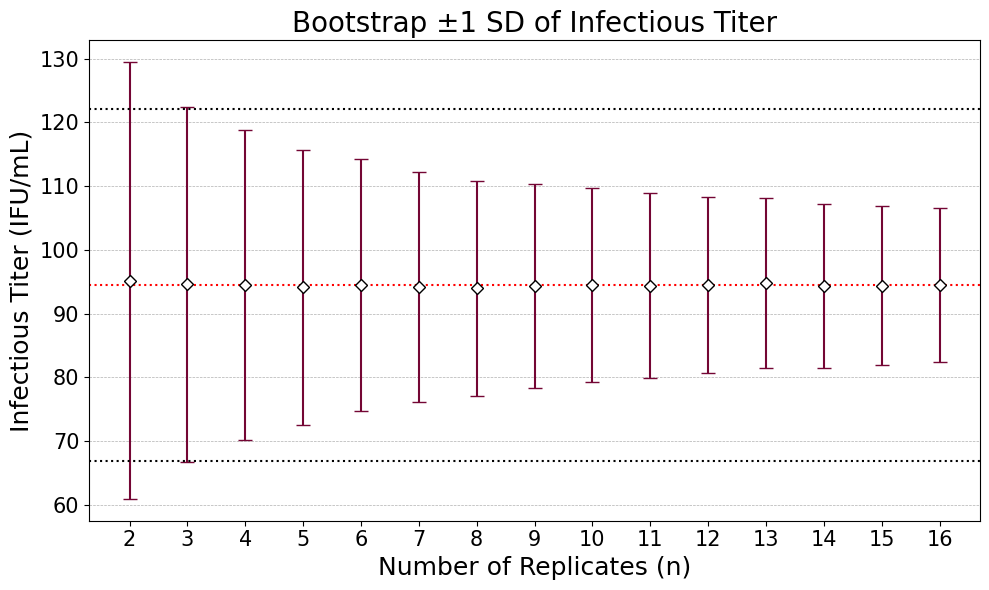

In [24]:
# ========== Step 4: Run ==========
Dilution = [(10000 * (10**(0.5 * i))) for i in range(11)]
file_path = r"96-384wReplicateStatistics.xlsx"  # Path to your Excel file
plot_sderrorbars(file_path, "0.5x384", "0.5x96", convert_to_titer=False,dilution_index=2)

Proposed FR count limits:
  Upper → DF = 9000, mean FR = 1049.8
  Lower → DF = 80000.0, mean FR ≈ 84.2 (closest to CV = 0.1)


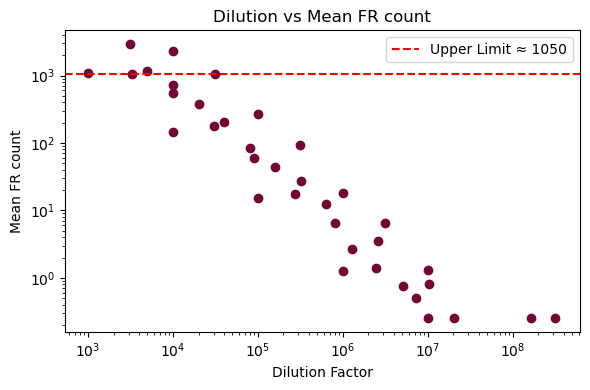

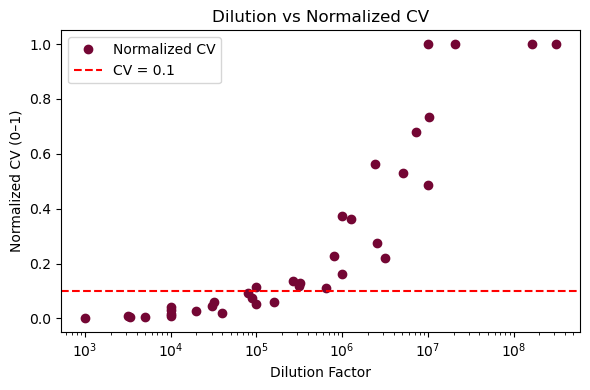

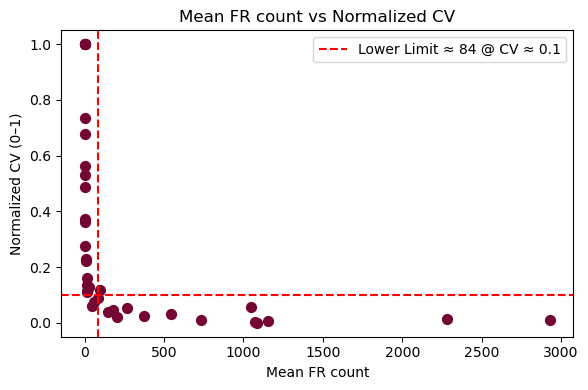

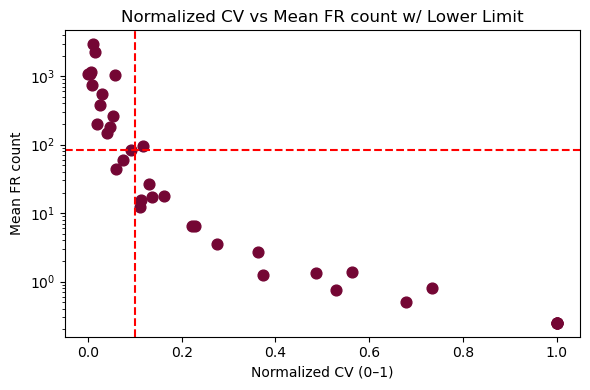

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# ========== Step 0: Load and Prepare Data ==========
file_path = r'C:/Users/jglts/OneDrive - McMaster University/SIMP-IT/Test222.xlsx'
sheet_name = "Sheet1"

df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
df = df.apply(pd.to_numeric, errors='coerce')
warnings.filterwarnings("ignore")

n_reps     = 16
n_blocks   = df.shape[1] // n_reps
folds      = [2, 3, 10,10**(0.5)]  # Dilution factors
# folds      = [10**(0.5)]
base_start = 1e4

# ========== Step 1: Compute per-block stats ==========
rows = []
for row_idx, fold in enumerate(folds):
    counts = df.iloc[row_idx].dropna().astype(float).values
    for b in range(n_blocks):  # skip positive control block 0
        vals = counts[b*n_reps:(b+1)*n_reps]
        m    = vals.mean()
        s    = vals.std(ddof=1)
        cv   = s/m if m != 0 else np.nan
        dfac = base_start * (fold**(b-1))
        rows.append({'DF': dfac, 'mean': m, 'std': s, 'cv': cv})

stats = pd.DataFrame(rows).sort_values('DF').reset_index(drop=True)

# ========== Step 2: Normalize CV ==========
stats['cv_norm'] = (stats['cv'] - stats['cv'].min()) / (stats['cv'].max() - stats['cv'].min())

# ========== Step 3: Determine Limits ==========

# Upper limit by R^2
def determine_upper_limit(df, r2_thresh=0.99):
    X = df['DF'].values.reshape(-1,1)
    y = df['mean'].values
    for i in range(2, len(X)+1):
        mdl = LinearRegression().fit(X[:i], y[:i])
        if r2_score(y[:i], mdl.predict(X[:i])) < r2_thresh:
            return df.loc[i-2, ['mean','DF']].values
    return df.loc[len(X)-1, ['mean','DF']].values

upper_fr, upper_df = determine_upper_limit(stats)

# Lower limit by closest normalized CV to 0.1
target_cv = 0.1
closest_idx = (stats['cv_norm'] - target_cv).abs().idxmin()
lower_fr = stats.loc[closest_idx, 'mean']
lower_df = stats.loc[closest_idx, 'DF']

print("Proposed FR count limits:")
# print(f"  Upper → DF = {upper_df:.0f}, mean FR = {upper_fr:.1f}")
print(f"  Upper → DF = 9000, mean FR = 1049.8")
print(f"  Lower → DF = {lower_df}, mean FR ≈ {lower_fr:.1f} (closest to CV = 0.1)")

# ========== Step 4: Plot 1 – Dilution vs Mean FR ==========
plt.figure(figsize=(6,4))
plt.plot(stats['DF'], stats['mean'], 'o', color='#740634')
plt.xscale('log')
plt.yscale('log')
plt.axhline(1049.8, color='red', linestyle='--', label=f'Upper Limit ≈ {1049.8:.0f}')
plt.xlabel('Dilution Factor')
plt.ylabel('Mean FR count')
plt.title('Dilution vs Mean FR count')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

# ========== Step 5: Plot 2 – Dilution vs Normalized CV ==========
plt.figure(figsize=(6,4))
plt.plot(stats['DF'], stats['cv_norm'], 'o', label='Normalized CV', color='#740634')
plt.axhline(0.1, color='red', linestyle='--', label='CV = 0.1')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Dilution Factor')
plt.ylabel('Normalized CV (0–1)')
plt.title('Dilution vs Normalized CV')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# ========== Step 6: Plot 3 – Mean FR vs Normalized CV ==========
plt.figure(figsize=(6,4))
plt.scatter(stats['mean'], stats['cv_norm'], s=50, color='#740634')
plt.axvline(lower_fr, color='red', linestyle='--', label=f'Lower Limit ≈ {lower_fr:.0f} @ CV ≈ 0.1')
plt.axhline(0.1, color='red', linestyle='--')
plt.xlabel('Mean FR count')
plt.ylabel('Normalized CV (0–1)')
plt.title('Mean FR count vs Normalized CV')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# ========== Step 7: Plot 4 – CV vs Mean with Threshold Lines ==========
plt.figure(figsize=(6,4))
plt.scatter(stats['cv_norm'], stats['mean'], s=60, color='#740634')
plt.axvline(0.1, color='red', linestyle='--')  # vertical at CV=0.1
plt.axhline(lower_fr, color='red', linestyle='--')  # horizontal at matched mean FR
plt.xlabel('Normalized CV (0–1)')
plt.yscale('log')
plt.ylabel('Mean FR count')
plt.title('Normalized CV vs Mean FR count w/ Lower Limit')
plt.grid(False)
plt.tight_layout()
plt.show()
